# Wikipedia Toxic Comment Classification

## Importing Libraries

In [1]:
#import library
import numpy as np 
import pandas as pd
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from matplotlib_venn import venn3
from wordcloud import WordCloud
from collections import Counter
import re
import string
from nltk.corpus import stopwords
stop = stopwords.words('english')
sns.set(style="white", context="talk")

In [2]:
dataset = pd.read_csv('Train/train.csv')
dataset.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


## Checking for null values

In [4]:
dataset.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [6]:
COLUMNS = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
# Adding 'none' columns if there is no '1' in COLUMNS
dataset['none'] = (dataset[COLUMNS].max(axis=1) == 0).astype(int)
COLUMNS.append('none')
CATEGORIES = COLUMNS.copy()
print(dataset.shape)
print(dataset.columns.values)

(159571, 9)
['id' 'comment_text' 'toxic' 'severe_toxic' 'obscene' 'threat' 'insult'
 'identity_hate' 'none']


## Checking Distribution of Data

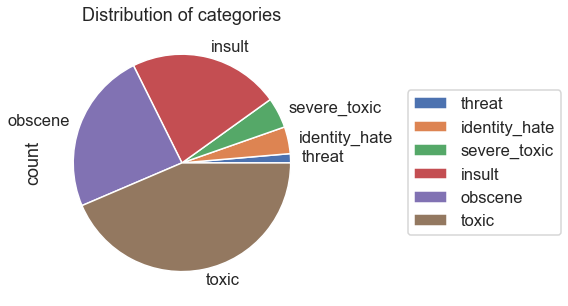

In [7]:
df_distribution = dataset[COLUMNS].sum()\
                            .to_frame()\
                            .rename(columns={0: 'count'})\
                            .sort_values('count')

df_distribution.drop('none').plot.pie(y='count',
                                      title='Distribution of categories',
                                      figsize=(5, 5))\
                            .legend(loc='center left', bbox_to_anchor=(1.3, 0.5))

In [8]:
df_distribution.sort_values('count', ascending=False)

,count
none,143346
toxic,15294
obscene,8449
insult,7877
severe_toxic,1595
identity_hate,1405
threat,478


In [9]:
dff = dataset.groupby(COLUMNS)\
                    .size()\
                    .sort_values(ascending=False)\
                    .reset_index()\
                    .rename(columns={0: 'count'})
dff.head(n=10)

,toxic,severe_toxic,obscene,threat,insult,identity_hate,none,count
0,0,0,0,0,0,0,1,143346
1,1,0,0,0,0,0,0,5666
2,1,0,1,0,1,0,0,3800
3,1,0,1,0,0,0,0,1758
4,1,0,0,0,1,0,0,1215
5,1,1,1,0,1,0,0,989
6,1,0,1,0,1,1,0,618
7,0,0,1,0,0,0,0,317
8,0,0,0,0,1,0,0,301
9,1,1,1,0,1,1,0,265


## Performing Correlation Analysis between existing features

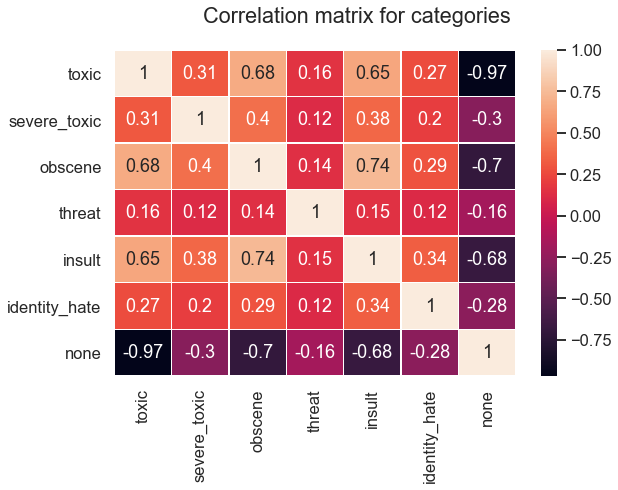

In [10]:
#Correlation matrix
f, ax = plt.subplots(figsize=(9, 6))
f.suptitle('Correlation matrix for categories')
sns.heatmap(dataset[COLUMNS].corr(), annot=True, linewidths=.5, ax=ax)


## Performing Correlation Analysis between existing and derived features

In [12]:
#Derived features correlation matrix
dataset['total_length'] = dataset['comment_text'].str.len()
dataset['new_big_space'] = dataset['comment_text'].str.count('\n'* 4)
dataset['uppercase_words'] = dataset['comment_text'].apply(lambda l: sum(map(str.isupper, list(l))))
dataset['exclamation_mark'] = dataset['comment_text'].str.count('!')

FEATURES = ['total_length', 
            'new_big_space', 
            'uppercase_words',
            'exclamation_mark']
COLUMNS += FEATURES

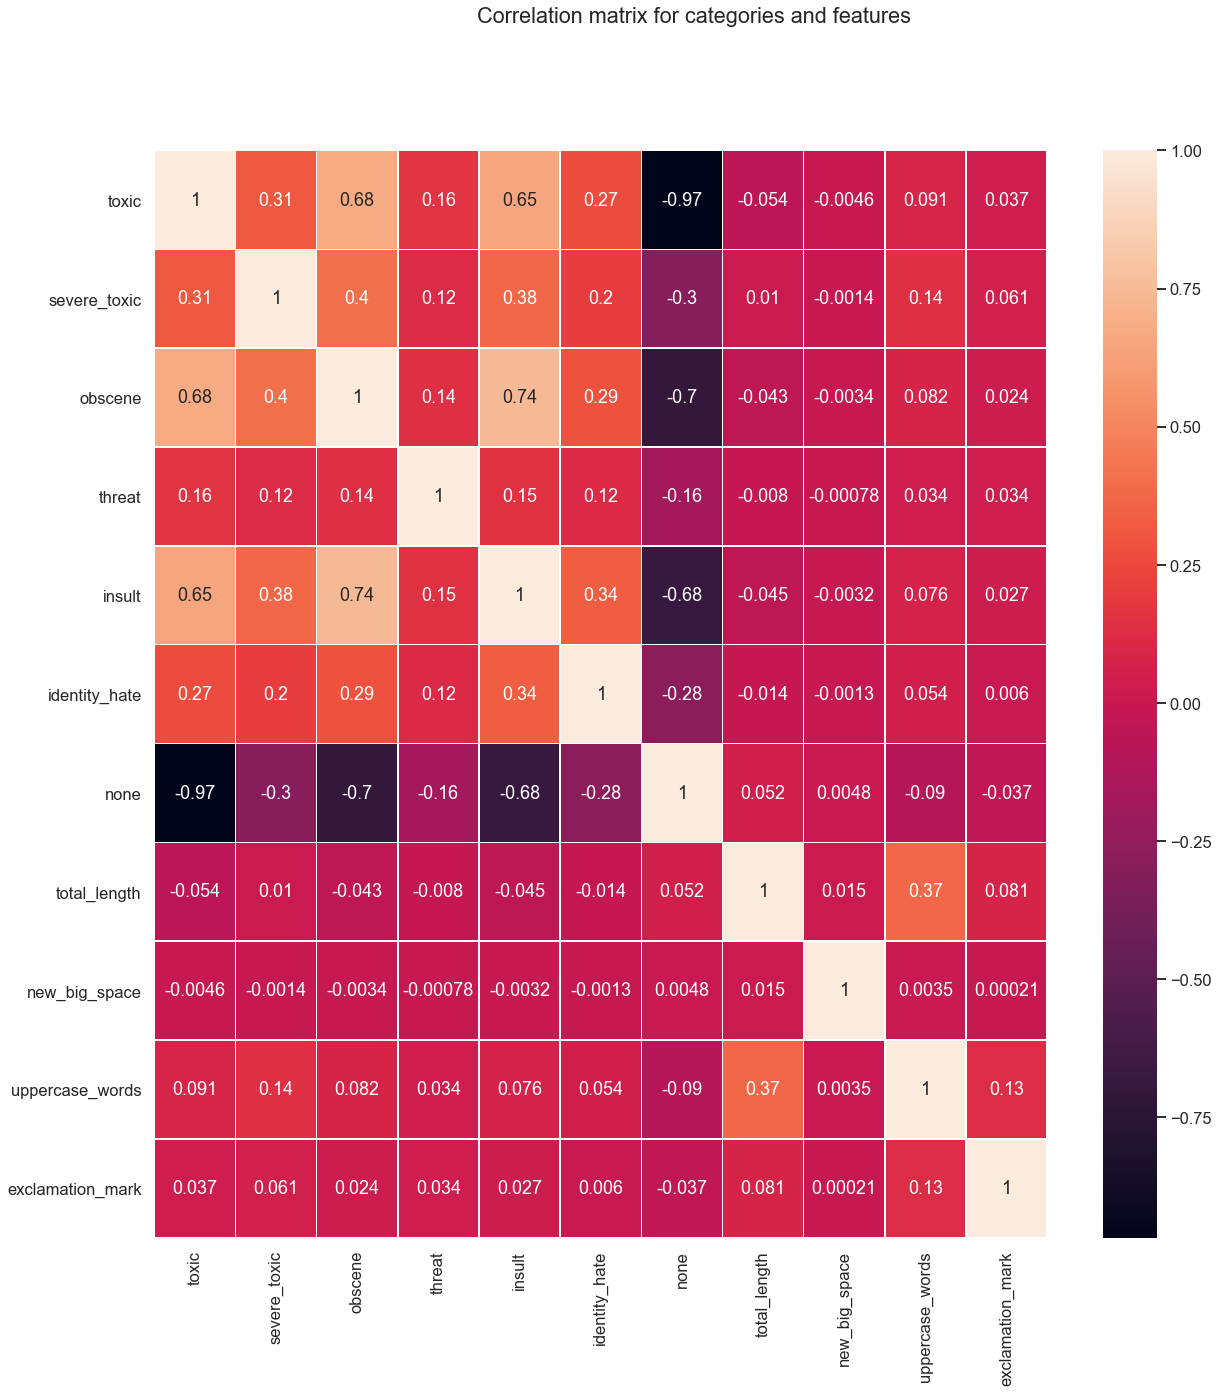

In [14]:
f, ax = plt.subplots(figsize=(20, 20))
f.suptitle('Correlation matrix for categories and features')
sns.heatmap(dataset[COLUMNS].corr(), annot=True, linewidths=.5, ax=ax)

# Word Analysis

In [15]:
word_counter = {}
def clean_text(text):
    text = re.sub('[{}]'.format(string.punctuation), ' ', text.lower())
    return ' '.join([word for word in text.split() if word not in (stop)])

for categ in CATEGORIES:
    d = Counter()
    dataset[dataset[categ] == 1]['comment_text'].apply(lambda t: d.update(clean_text(t).split()))
    word_counter[categ] = pd.DataFrame.from_dict(d, orient='index')\
                                        .rename(columns={0: 'count'})\
                                        .sort_values('count', ascending=False)

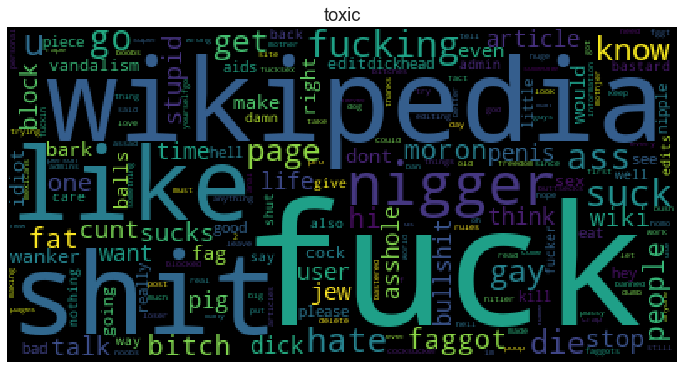

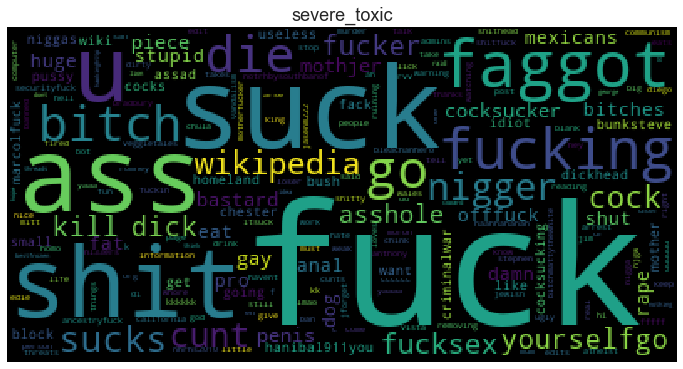

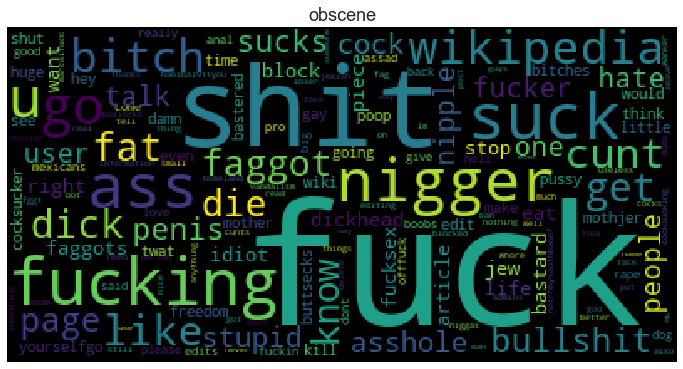

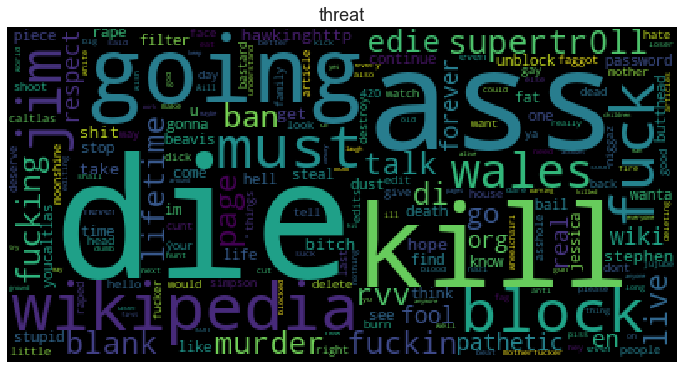

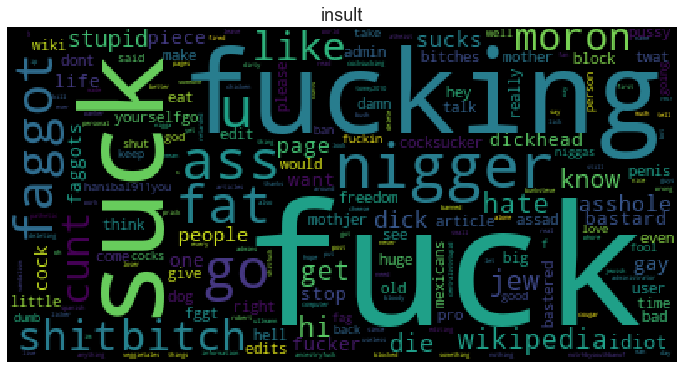

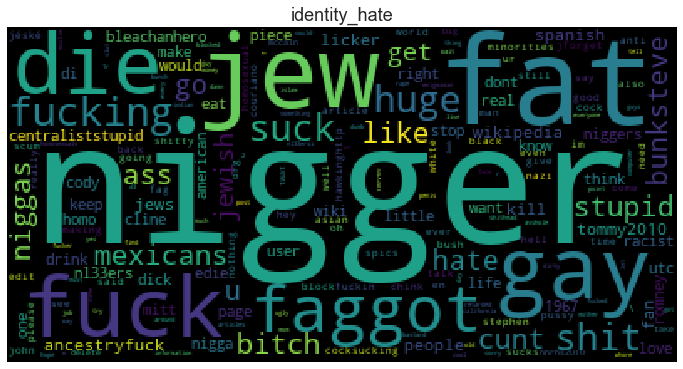

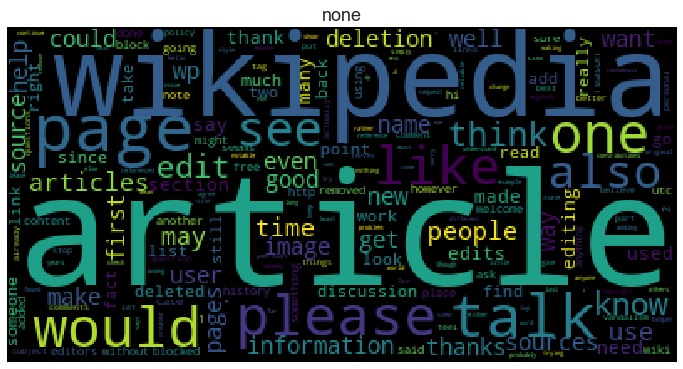

In [16]:
for w in word_counter:
    wc = word_counter[w]

    wordcloud = WordCloud(
          background_color='black',
          max_words=200,
          max_font_size=100, 
          random_state=4561
         ).generate_from_frequencies(wc.to_dict()['count'])

    fig = plt.figure(figsize=(12, 8))
    plt.title(w)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

In [17]:
sentiment = dataset['comment_text'].values
y_list = ["toxic","severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = dataset[y_list].values

# Implementing Bi-LSTM model to perform multi-label classification

## Performing tokenizing on words and pre-processing of data

In [18]:
#Tokenizing and Padding train and test set
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(list(sentiment))

In [19]:
from keras.preprocessing import text, sequence

seq = tokenizer.texts_to_sequences(sentiment)
pad = sequence.pad_sequences(seq, maxlen=100)

In [8]:
#Preparing test set
test = pd.read_csv('Test/test.csv')
test = test['comment_text'].values
test_seq = tokenizer.texts_to_sequences(test)
test_pad = sequence.pad_sequences(test_seq, maxlen=100)

In [87]:
# Defining metrics
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [90]:
#Model Building
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers


def model_add():
    inputs = Input(shape=(100, ))
    x = Embedding(20000, 128)(inputs)
    x = Bidirectional(LSTM(50))(x)
    x = Dropout(0.1)(x)
    x = Dense(50, activation="relu")(x)
    x = Dropout(0.1)(x)
    outputs = Dense(6, activation="sigmoid")(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy',f1_m,precision_m,recall_m])
    return model
model = model_add()
print(model.summary())

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 100, 128)          2560000   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 100)               71600     
_________________________________________________________________
dropout_6 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_7 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 6)                

In [91]:
#Early Stopping
from keras.callbacks import EarlyStopping, ModelCheckpoint
early = EarlyStopping(monitor="val_loss", mode="min", patience=20)
model.fit(pad, y, batch_size=1024, epochs=2, validation_split=0.3, callbacks=early)

Epoch 1/2
110/110 [==============================] - 92s 834ms/step - loss: 0.2179 - accuracy: 0.5022 - f1_m: 0.0120 - precision_m: 0.0549 - recall_m: 0.0236 - val_loss: 0.1004 - val_accuracy: 0.9845 - val_f1_m: 0.0079 - val_precision_m: 0.1529 - val_recall_m: 0.0041
Epoch 2/2
110/110 [==============================] - 99s 899ms/step - loss: 0.0682 - accuracy: 0.9148 - f1_m: 0.5873 - precision_m: 0.7641 - recall_m: 0.5143 - val_loss: 0.0559 - val_accuracy: 0.9940 - val_f1_m: 0.7077 - val_precision_m: 0.7683 - val_recall_m: 0.6574


In [159]:
predictions = model.predict([test_pad], batch_size=1024, verbose=1)
test_output = pd.read_csv('Testlabel/test_labels.csv')
test_output[y_list] = predictions

150/150 [==============================] - 27s 179ms/step


In [197]:
true_label=pd.read_csv('Testlabel/test_label.csv')
actual=true_label.drop(['id'],axis=1).to_numpy()
true_label

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,1,1,1,1,1,1
1,0000247867823ef7,1,1,1,1,1,1
2,00013b17ad220c46,1,1,1,1,1,1
3,00017563c3f7919a,1,1,1,1,1,1
4,00017695ad8997eb,1,1,1,1,1,1
...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,1,1,1,1,1,1
153160,fffd7a9a6eb32c16,1,1,1,1,1,1
153161,fffda9e8d6fafa9e,1,1,1,1,1,1
153162,fffe8f1340a79fc2,1,1,1,1,1,1


In [211]:
loss, accuracy,f1,precision,recall=model.evaluate(t,actual,batch_size=250, verbose=0)

In [213]:
print(accuracy)

0.9990010857582092
